In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q kaggle
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ahmedyasserelshrkawy","key":"60dd6ae8d53f3d656f066c6b0567d0b3"}'}

In [1]:
!kaggle datasets download -d tristanzhang32/ai-generated-images-vs-real-images -p /content/ai-generated-images-vs-real-images

Dataset URL: https://www.kaggle.com/datasets/tristanzhang32/ai-generated-images-vs-real-images
License(s): MIT
100% 48.4G/48.4G [06:39<00:00, 139MB/s]
100% 48.4G/48.4G [06:39<00:00, 130MB/s]


In [2]:
!unzip /content/ai-generated-images-vs-real-images/ai-generated-images-vs-real-images.zip -d /content/ai-generated-images-vs-real-images-images

Streaming output truncated to the last 5000 lines.
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5000.jpg  
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5001.jpg  
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5002.jpg  
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5003.jpg  
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5004.jpg  
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5005.jpg  
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5006.jpg  
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5007.jpg  
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5008.jpg  
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5009.jpg  
  inflating: /content/ai-generated-images-vs-real-images-images/train/real/5010.jpg  
  i

In [5]:

import numpy as np
import pandas as pd
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image, ImageFile
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore", Image.DecompressionBombWarning)


In [6]:
# Define dataset path
data_dir = '/content/ai-generated-images-vs-real-images-images/train'


Image.MAX_IMAGE_PIXELS = None

def convert_to_rgb(image):
    if image.mode == 'P':
        image = image.convert("RGBA")
    if image.mode == "RGBA":
        background = Image.new("RGB", image.size, (255, 255, 255))
        image = Image.alpha_composite(background, image).convert("RGB")
    elif image.mode != "RGB":
        image = image.convert("RGB")
    return image

def resize_large_image(image, max_size):
    if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
        image.thumbnail(max_size, Image.Resampling.LANCZOS)
    return image

# Define transformations
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),
    transforms.Lambda(convert_to_rgb),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ImageFile.LOAD_TRUNCATED_IMAGES = True
MIN_IMAGE_FILE_SIZE = 3284

def is_valid_image(file_path):
    try:
        if os.path.getsize(file_path) < MIN_IMAGE_FILE_SIZE:
            return False
        with Image.open(file_path) as img:
            img.verify()
        return True
    except (OSError, Image.DecompressionBombError):
        return False

class ValidImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.samples = [(path, label) for path, label in self.samples if is_valid_image(path)]
        self.targets = [label for _, label in self.samples]

# Load dataset
dataset = ValidImageFolder(root=data_dir, transform=train_transform)

In [7]:
print(f"Original Dataset Size: {len(dataset)}")

Original Dataset Size: 47998


In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
# train_size = int(0.8 * len(balanced_subset))
# val_size = len(balanced_subset) - train_size
# train_dataset, val_dataset = random_split(balanced_subset, [train_size, val_size])

# val_dataset.dataset.transform = val_transform

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [9]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Train Dataset Size: 38398
Validation Dataset Size: 9600


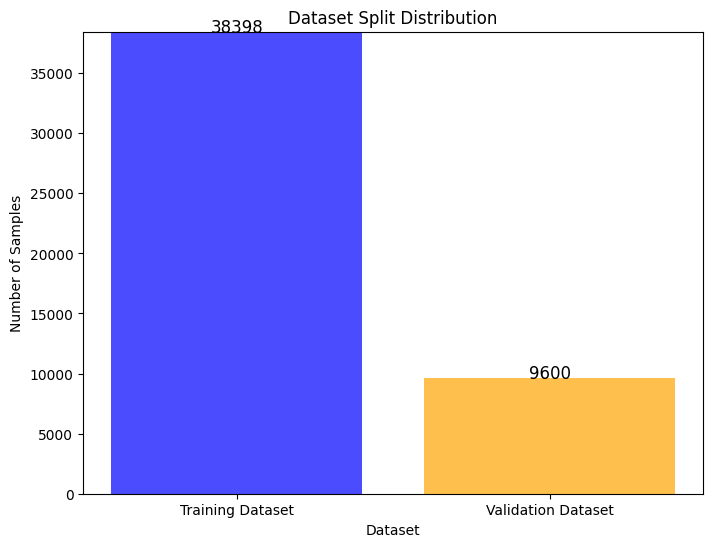

In [10]:
import matplotlib.pyplot as plt

train_size = len(train_dataset)
val_size = len(val_dataset)

labels = ['Training Dataset', 'Validation Dataset']
sizes = [train_size, val_size]

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['blue', 'orange'], alpha=0.7)

for i, size in enumerate(sizes):
    plt.text(i, size + 5, str(size), ha='center', fontsize=12)

plt.title('Dataset Split Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Dataset')
plt.ylim(0, max(sizes) + 50)
plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
import torchvision.models as models

model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

# Modify the classifier layer to match the number of classes (e.g., 2 for binary classification)
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 2)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 139MB/s] 


In [13]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [14]:
# Training and validation loop
patience = 6
trigger_times = 0
best_val_loss = float('inf')
epochs = 16
best_val_acc = 0.0

data = {
    "train_losses": [],
    "train_accuracies": [],
    "val_losses": [],
    "val_accuracies": [],
}

In [15]:
import os

folder_name = "Saved_status_model"
os.makedirs(folder_name, exist_ok=True)  # Creates the folder if it doesn't exist
print(f"Folder '{folder_name}' created successfully!")


Folder 'Saved_status_model' created successfully!


In [16]:
cd /content/Saved_status_model/

/content/Saved_status_model


In [17]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    data["train_losses"].append(epoch_loss)
    data["train_accuracies"].append(epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    data["val_losses"].append(val_loss)
    data["val_accuracies"].append(val_acc.item())

    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    if val_acc > best_val_acc:
        best_val_acc = val_acc

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model{epoch}_mobilenetv3_small.pth')
        trigger_times = 0  # Reset early stopping counter
    else:
        trigger_times += 1
        print(f"Early stopping trigger count: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping...")
            break

    # Step the scheduler
    scheduler.step()

print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Best Validation Loss: {best_val_loss:.4f}')

Epoch 1/16


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2080 Acc: 0.9167
Val Loss: 0.2551 Acc: 0.9109

Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.93      0.91      4797
        real       0.93      0.89      0.91      4803

    accuracy                           0.91      9600
   macro avg       0.91      0.91      0.91      9600
weighted avg       0.91      0.91      0.91      9600

Epoch 2/16


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1282 Acc: 0.9511
Val Loss: 0.1956 Acc: 0.9274

Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.90      0.93      4797
        real       0.91      0.95      0.93      4803

    accuracy                           0.93      9600
   macro avg       0.93      0.93      0.93      9600
weighted avg       0.93      0.93      0.93      9600

Epoch 3/16


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0927 Acc: 0.9652
Val Loss: 0.9036 Acc: 0.7807

Classification Report:
              precision    recall  f1-score   support

        fake       0.70      0.99      0.82      4797
        real       0.98      0.57      0.72      4803

    accuracy                           0.78      9600
   macro avg       0.84      0.78      0.77      9600
weighted avg       0.84      0.78      0.77      9600

Early stopping trigger count: 1/6
Epoch 4/16


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0313 Acc: 0.9897
Val Loss: 0.1331 Acc: 0.9623

Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.95      0.96      4797
        real       0.95      0.97      0.96      4803

    accuracy                           0.96      9600
   macro avg       0.96      0.96      0.96      9600
weighted avg       0.96      0.96      0.96      9600

Epoch 5/16


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0122 Acc: 0.9960
Val Loss: 0.1495 Acc: 0.9628

Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.96      0.96      4797
        real       0.96      0.97      0.96      4803

    accuracy                           0.96      9600
   macro avg       0.96      0.96      0.96      9600
weighted avg       0.96      0.96      0.96      9600

Early stopping trigger count: 1/6
Epoch 6/16


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0061 Acc: 0.9983
Val Loss: 0.1813 Acc: 0.9606

Classification Report:
              precision    recall  f1-score   support

        fake       0.96      0.96      0.96      4797
        real       0.96      0.96      0.96      4803

    accuracy                           0.96      9600
   macro avg       0.96      0.96      0.96      9600
weighted avg       0.96      0.96      0.96      9600

Early stopping trigger count: 2/6
Epoch 7/16


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0036 Acc: 0.9990
Val Loss: 0.1771 Acc: 0.9632

Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.96      0.96      4797
        real       0.96      0.97      0.96      4803

    accuracy                           0.96      9600
   macro avg       0.96      0.96      0.96      9600
weighted avg       0.96      0.96      0.96      9600

Early stopping trigger count: 3/6
Epoch 8/16


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0031 Acc: 0.9991
Val Loss: 0.1796 Acc: 0.9642

Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.96      0.96      4797
        real       0.96      0.97      0.96      4803

    accuracy                           0.96      9600
   macro avg       0.96      0.96      0.96      9600
weighted avg       0.96      0.96      0.96      9600

Early stopping trigger count: 4/6
Epoch 9/16


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0027 Acc: 0.9993
Val Loss: 0.1832 Acc: 0.9651

Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.96      0.96      4797
        real       0.96      0.97      0.97      4803

    accuracy                           0.97      9600
   macro avg       0.97      0.97      0.97      9600
weighted avg       0.97      0.97      0.97      9600

Early stopping trigger count: 5/6
Epoch 10/16


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0024 Acc: 0.9994
Val Loss: 0.1837 Acc: 0.9651

Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.96      0.96      4797
        real       0.96      0.97      0.97      4803

    accuracy                           0.97      9600
   macro avg       0.97      0.97      0.97      9600
weighted avg       0.97      0.97      0.97      9600

Early stopping trigger count: 6/6
Early stopping...
Best Validation Accuracy: 0.9651
Best Validation Loss: 0.1331


In [18]:
df = pd.DataFrame(data)

In [19]:
print(data)

{'train_losses': [0.2080325738749682, 0.12823182474285297, 0.09268196745857087, 0.031275201954723296, 0.012158368789463851, 0.006122564880084338, 0.003600401739546503, 0.00313118050932202, 0.0026772261932570354, 0.002396257182981374], 'train_accuracies': [0.916662326162821, 0.9510651596437314, 0.9652065211729778, 0.9896869628626491, 0.9959893744465858, 0.9982811604771081, 0.9989843221001093, 0.9991145372154799, 0.999348924423147, 0.9994270534923694], 'val_losses': [0.2551302330692609, 0.195616614818573, 0.9036275323232015, 0.13306500047445297, 0.1495413330818216, 0.18131584520141283, 0.17706358026713132, 0.1795588331669569, 0.1832271101201574, 0.18374459685136874], 'val_accuracies': [0.9109375000000001, 0.9273958333333334, 0.7807291666666667, 0.9622916666666668, 0.9628125000000001, 0.9606250000000001, 0.9632291666666667, 0.9641666666666667, 0.9651041666666668, 0.9651041666666668]}


In [20]:
df

,train_losses,train_accuracies,val_losses,val_accuracies
0,0.208033,0.916662,0.255130,0.910938
1,0.128232,0.951065,0.195617,0.927396
2,0.092682,0.965207,0.903628,0.780729
3,0.031275,0.989687,0.133065,0.962292
4,0.012158,0.995989,0.149541,0.962813
5,0.006123,0.998281,0.181316,0.960625
6,0.003600,0.998984,0.177064,0.963229
7,0.003131,0.999115,0.179559,0.964167
8,0.002677,0.999349,0.183227,0.965104
9,0.002396,0.999427,0.183745,0.965104


In [21]:
df.to_csv("MobileNet_2V3ofData.csv", index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


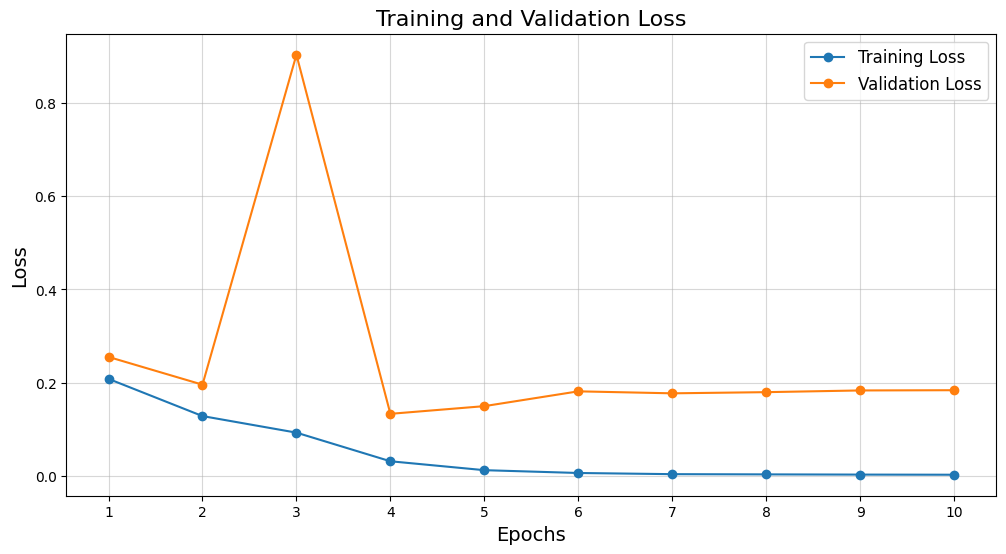

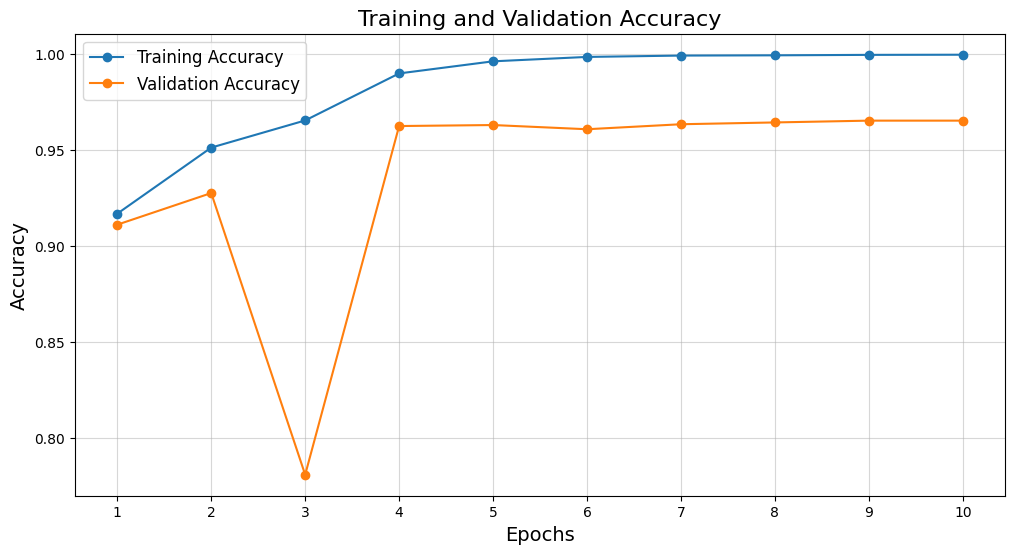

In [22]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_losses"]) + 1), data["train_losses"], label='Training Loss', marker='o')
plt.plot(range(1, len(data["val_losses"]) + 1), data["val_losses"], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(1, len(data["train_losses"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_accuracies"]) + 1), data["train_accuracies"], label='Training Accuracy', marker='o')
plt.plot(range(1, len(data["val_accuracies"]) + 1), data["val_accuracies"], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(1, len(data["train_accuracies"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# TESTING in TESTING DATA

In [23]:
data_dir = '/content/ai-generated-images-vs-real-images-images/test'

Image.MAX_IMAGE_PIXELS = None

Image.MAX_IMAGE_PIXELS = 200000000

def convert_to_rgb(image):
    if image.mode == 'P':
        image = image.convert("RGBA")
    if image.mode == "RGBA":
        background = Image.new("RGB", image.size, (255, 255, 255))
        image = Image.alpha_composite(background, image).convert("RGB")
    elif image.mode != "RGB":
        image = image.convert("RGB")
    return image


def resize_large_image(image, max_size):
    if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
        image.thumbnail(max_size, Image.Resampling.LANCZOS)
    return image

train_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),
    transforms.Lambda(convert_to_rgb),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



val_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ImageFile.LOAD_TRUNCATED_IMAGES = True

MIN_IMAGE_FILE_SIZE = 3284  # 1 KB (adjust as needed)

def is_valid_image(file_path):
    try:
        if os.path.getsize(file_path) < MIN_IMAGE_FILE_SIZE:
            return False

        with Image.open(file_path) as img:
            img.verify()
        return True
    except (OSError, Image.DecompressionBombError):
        return False


class ValidImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        # Filter out invalid images
        self.samples = [(path, label) for path, label in self.samples if is_valid_image(path)]
        self.targets = [label for _, label in self.samples]

dataset = ValidImageFolder(root=data_dir, transform=val_transform)

In [24]:
batch_size=128

test_loader = DataLoader(dataset, batch_size=128, shuffle=False)

print(f"Test Dataset Size: {len(test_loader)*128 }")

Test Dataset Size: 12032


In [25]:
criterion = nn.CrossEntropyLoss()

# Validation phase
model.eval()
test_loss = 0.0
test_corrects = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Accumulate loss and correct predictions
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data).item()

        # Store predictions and labels for metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute average loss and accuracy
test_loss = test_loss / len(test_loader.dataset)  # Divide by total number of samples
test_acc = test_corrects / len(test_loader.dataset)  # Correct accuracy calculation

print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

# Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Loss: 0.1812 Acc: 0.9623

Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.96      0.96      6000
        real       0.96      0.97      0.96      5999

    accuracy                           0.96     11999
   macro avg       0.96      0.96      0.96     11999
weighted avg       0.96      0.96      0.96     11999



In [27]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

all_true_labels = np.array(all_labels)
all_preds_MobileNet_V3_Large = np.array(all_preds )

def calculate_scores(true_labels, predictions, model_name):
    accuracy = accuracy_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions, average='weighted')
    precision = precision_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")

calculate_scores(all_true_labels, all_preds_MobileNet_V3_Large, "MobileNet V3 Large")


MobileNet V3 Large - Accuracy: 0.9623, Recall: 0.9623, Precision: 0.9624, F1 Score: 0.9623


In [ ]:
sssscvdfffsawercxvsscfgssssssssssssssss